# Data ingestion and ELT from object store

NPS can load and unload data from object stores like Amazon S3 and IBM Cloud object store. This works by [using Netezza External Tables to read from and write to object store](https://www.ibm.com/support/knowledgecenter/SS5FPD_1.0.0/com.ibm.ips.doc/postgresql/load/c_load_loading_cloud.html). 

Lets take a look at a few examples; lets target an AWS S3 bucket. Prerequisites - 

- `NZ_USER`, `NZ_PASSWORD`, `NZ_HOST` environment variables are set to point to the right Netezza instance
- `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY` and `AWS_REGION` environment variables are set with the correct credentials
- `BUCKET` environment variable has the correct bucket name

_Note:_ One can configure the ACLs for the bucket on AWS like [this](https://www.ibm.com/support/knowledgecenter/en/SSTNZ3/com.ibm.ips.doc/postgresql/admin/adm_nps_cloud_provisioning_prereq_aws.html) to balance security and need for NPS to read/write to it.


## The sample data

Lets use the [publically available Covid case data](https://github.com/owid/covid-19-data/tree/master/public/data) to highlight this NPS use case. For this example, the data has been put in an object store bucket (`$BUCKET`) under `/covid/owid-covid-data.csv`

In [2]:
import os, nzpy
import pandas as pd
con = nzpy.connect(user=os.environ['NZ_USER'], password=os.environ['NZ_PASSWORD'], host=os.environ['NZ_HOST'],
                   port=5480, database='system')

There are two examples here. 

- Load data into the database and do some analysis
- Use transient external tables to read (on the fly) data and perform some analysis

The schema for the table is [published by OWID already](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

In [3]:
# Setup the table schema based on the json mentioned above
schema = '''
    iso_code varchar (16),
    continent varchar(48),
    location varchar(48),
    covid_date date,
    total_cases numeric(32, 20),
    new_cases numeric(32, 20),
    new_cases_smoothed numeric(32, 20),
    total_deaths numeric(32, 20),
    new_deaths numeric(32, 20),
    new_deaths_smoothed numeric(32, 20),
    total_cases_per_million numeric(32, 20),
    new_cases_per_million numeric(32, 20),
    new_cases_smoothed_per_million numeric(32, 20),
    total_deaths_per_million numeric(32, 20),
    new_deaths_per_million numeric(32, 20),
    new_deaths_smoothed_per_million numeric(32, 20),
    new_tests numeric(32, 20),
    total_tests numeric(32, 20),
    total_tests_per_thousand numeric(32, 20),
    new_tests_per_thousand numeric(32, 20),
    new_tests_smoothed numeric(32, 20),
    new_tests_smoothed_per_thousand numeric(32, 20),
    tests_per_case numeric(32, 20),
    positive_rate numeric(32, 20),
    tests_units varchar(32),
    stringency_index numeric(32, 20),
    population numeric(32, 20),
    population_density numeric(32, 20),
    median_age numeric(32, 20),
    aged_65_older numeric(32, 20),
    aged_70_older numeric(32, 20),
    gdp_per_capita numeric(32, 20),
    extreme_poverty numeric(32, 20),
    cardiovasc_death_rate numeric(32, 20),
    diabetes_prevalence numeric(32, 20),
    female_smokers numeric(32, 20),
    male_smokers numeric(32, 20),
    handwashing_facilities numeric(32, 20),
    hospital_beds_per_thousand numeric(32, 20),
    life_expectancy numeric(32, 20),
    human_development_index numeric(32, 20)'''

# Read data on the fly and lets see if all is working well. 
df = pd.read_sql(f'''
    select unique(continent)
    from external 'owid-covid-data.csv' ({schema})
    using (
        remotesource 'S3' 
        delim ','
        uniqueid 'covid' 
        accesskeyid '{os.environ["AWS_ACCESS_KEY_ID"]}'
        secretaccesskey '{os.environ["AWS_SECRET_ACCESS_KEY"]}'
        defaultregion '{os.environ["AWS_REGION"]}'
        bucketurl '{os.environ["BUCKET"]}'
        skiprows 1
    ) where continent is not null and continent != '' ''', con)
df.columns = [c.decode().lower() for c in df.columns]
df

,continent
0,North America
1,Asia
2,Africa
3,Europe
4,South America
5,Oceania


In [4]:
# Ingest the data and do analysis and visualization
table = 'covid'
with con.cursor() as cur:
    # drop any old table
    r = cur.execute(f'select 1 from _v_table where tablename = ^{table}^')
    if r.fetchall():
        cur.execute(f'drop table {table}')
        
    # create a table to load data
    cur.execute(f'create table {table} ({schema})')
    print(f"Table {table} created")
    
    # load data from object store
    cur.execute(f'''
    insert into {table} 
        select * from external 'owid-covid-data.csv' ({schema})
        using (
            remotesource 'S3' 
            delim ','
            uniqueid 'covid' 
            accesskeyid '{os.environ["AWS_ACCESS_KEY_ID"]}'
            secretaccesskey '{os.environ["AWS_SECRET_ACCESS_KEY"]}'
            defaultregion '{os.environ["AWS_REGION"]}'
            bucketurl '{os.environ["BUCKET"]}'
            skiprows 1
        )''')
    print(f"{cur.rowcount} Rows loaded")

Table covid created
52873 Rows loaded


In [5]:
# Get a week over week trend
df = pd.read_sql_query('''
    select continent,
            this_week(covid_date) as wk,
            max(new_cases) as total 
    from covid 
    where 
        continent is not null and
        continent != ''
    group by wk, continent
    order by wk, continent
    ''', con,
    parse_dates = {b'WK': '%Y-%m-%d'})
df.columns = [c.decode().lower() for c in df.columns]
df.total = df.total.astype(float)
df.head()

,continent,wk,total
0,Africa,2019-12-29,0.0
1,Asia,2019-12-29,27.0
2,Europe,2019-12-29,0.0
3,North America,2019-12-29,0.0
4,Oceania,2019-12-29,0.0


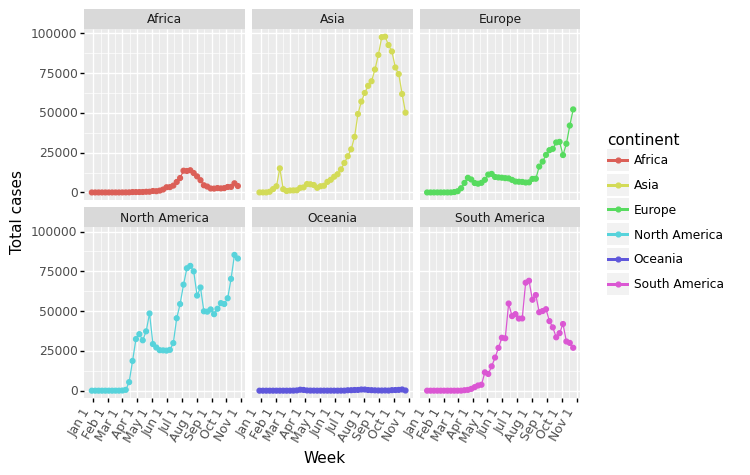

<ggplot: (313037276)>

In [6]:
# Lets visualize the same
from mizani.formatters import date_format
from plotnine import *

( ggplot(df, aes(x='wk', y='total', color='continent')) + geom_line() + geom_point() + 
  labs(y = "Total cases", x = "Week") + facet_wrap('continent') + 
   scale_x_datetime(labels=date_format('%b %-d')) +
   theme(axis_text_x=element_text(rotation=60, hjust=1))
)